# Solve for transition path in Ramsey-model

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

## 1. <a id='toc1_'></a>[Paramters](#toc0_)

In [2]:
Gamma_ss = 1.0
alpha = 0.36
beta = 0.96
delta = 0.10
sigma = 2.0

## 2. <a id='toc2_'></a>[Steady state](#toc0_)

In [3]:
K_ss = ((1/beta-1+delta)/(Gamma_ss*alpha))**(1/(alpha-1))
C_hh_ss = (1-delta)*K_ss+Gamma_ss*K_ss**alpha-K_ss

print(f'{K_ss = :.4f}')
print(f'{C_hh_ss = :.4f}')

K_ss = 4.2940
C_hh_ss = 1.2604


In [4]:
def rK_func(Gamma,K_lag):
    return Gamma*alpha*K_lag**(alpha-1)

def w_func(Gamma,K_lag):
    return Gamma*(1-alpha)*K_lag**(alpha)

In [5]:
rK_ss = rK_func(Gamma_ss,K_ss)
r_ss = rK_ss-delta
w_ss = w_func(Gamma_ss,K_ss)

print(f'{rK_ss = :.4f}')
print(f'{r_ss = :.4f}')
print(f'{w_ss = :.4f}')

rK_ss = 0.1417
r_ss = 0.0417
w_ss = 1.0815


## 3. <a id='toc3_'></a>[Truncated equation system](#toc0_)

In [6]:
T = 200

In [7]:
def H(K_ini_lag,C_hh_ss,Gamma,K,T):

    # a. allocate
    rK = np.zeros(T)
    w = np.zeros(T)
    C_hh = np.zeros(T)
    A_hh = np.zeros(T)

    # block: production firm [K_lag -> rK,r]
    for t in range(T):

        if t == 0:
            K_lag = K_ini_lag
        else:
            K_lag = K[t-1]

        rK[t] = rK_func(Gamma[t],K_lag)
        w[t] = w_func(Gamma[t],K_lag)

    # block: mutual fund: K,rK -> A,r
    A = K
    r = rK-delta

    # block: household [r,w->C,A_hh]
    for k in range(T): # backwards on Euler

        t = T-1-k

        if k == 0:  
            C_hh_plus = C_hh_ss 
            r_plus = r_ss 
        else:
            C_hh_plus = C_hh[t+1]
            r_plus = r[t+1]

        C_hh[t] = (beta*(1+r_plus))**(-1/sigma)*C_hh_plus

    for t in range(T): # forwards on budget constraint

        if t == 0:
            A_hh_lag = K_ini_lag # previous clearing
        else:
            A_hh_lag = A_hh[t-1]

        A_hh[t] = (1+r[t])*A_hh_lag + w[t] - C_hh[t]        
    
    # block: market clearing
    clearing_A = A-A_hh
    return clearing_A,C_hh

Test errors:

In [8]:
errors,_ = H(K_ss,C_hh_ss,np.repeat(Gamma_ss,T),np.repeat(K_ss,T),T)
assert np.allclose(errors,0) 

## 4. <a id='toc4_'></a>[Jacobian](#toc0_)

In [9]:
def calc_jac(T,Delta=1e-4):
    
    jac = np.zeros((T,T))

    for s in range(T):

        K = np.repeat(K_ss,T)
        K[s] += Delta
        
        errors,_ = H(K_ss,C_hh_ss,np.repeat(Gamma_ss,T),K,T)
        jac[:,s] = errors/Delta

    return jac

In [10]:
jac = calc_jac(T)

## 5. <a id='toc5_'></a>[Find transition path](#toc0_)

In [11]:
from GEModelTools import broyden_solver

### 5.1. <a id='toc5_1_'></a>[Low initial capital](#toc0_)

In [12]:
Gamma_path = np.repeat(Gamma_ss,T)
K_ini = K_ss*0.75

def obj(x):
    errors,_ = H(K_ini,C_hh_ss,Gamma_path,x,T)
    return errors

K_path_guess = np.repeat(K_ss,T)
K_path = broyden_solver(obj,K_path_guess,jac,do_print=True)
_,C_hh_path = H(K_ini,C_hh_ss,Gamma_path,K_path,T)

 it =   0 -> max. abs. error = 3.82e+03
 it =   1 -> max. abs. error = 9.96e+01
 it =   2 -> max. abs. error = 1.45e+01
 it =   3 -> max. abs. error = 3.05e-01
 it =   4 -> max. abs. error = 1.00e-02
 it =   5 -> max. abs. error = 3.33e-04
 it =   6 -> max. abs. error = 6.66e-06
 it =   7 -> max. abs. error = 5.28e-08
 it =   8 -> max. abs. error = 4.64e-10


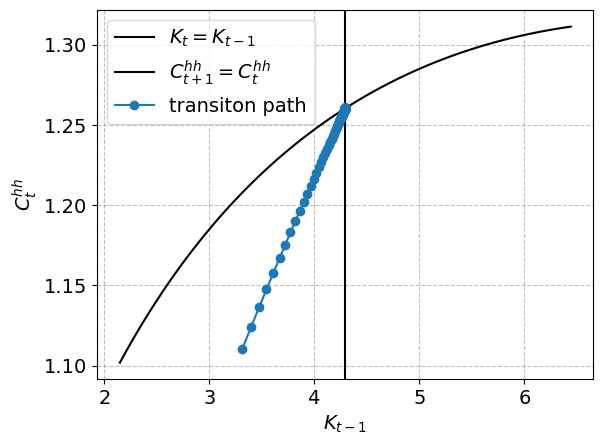

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

K_lag = np.linspace(K_ss/2,K_ss*1.5,100)

K_constant = (1-delta)*K_lag+Gamma_ss*K_lag**alpha-K_lag
ax.plot(K_lag,K_constant,label='$K_{t}=K_{t-1}$',color='black')
ax.axvline(K_ss,label='$C^{hh}_{t+1}=C^{hh}_t$',color='black')

ax.plot(K_path,C_hh_path,'-o',label='transiton path')

ax.set_xlabel('$K_{t-1}$')
ax.set_ylabel('$C^{hh}_{t}$')
ax.legend(frameon=True)
fig.savefig('figs/K_ini_lag.pdf')

### 5.2. <a id='toc5_2_'></a>[Technology shock](#toc0_)

In [14]:
Gamma_path = Gamma_ss + 0.01*Gamma_ss*0.95**np.arange(T)
K_ini = K_ss

def obj(x):
    errors,C = H(K_ini,C_hh_ss,Gamma_path,x,T)
    return errors

K_path_guess = np.repeat(K_ss,T)
K_path = broyden_solver(obj,K_path_guess,jac,do_print=True)
_,C_hh_path = H(K_ini,C_hh_ss,Gamma_path,K_path,T)

 it =   0 -> max. abs. error = 1.29e+03
 it =   1 -> max. abs. error = 1.69e+01
 it =   2 -> max. abs. error = 1.70e-01
 it =   3 -> max. abs. error = 1.53e-02
 it =   4 -> max. abs. error = 1.27e-05
 it =   5 -> max. abs. error = 3.83e-06
 it =   6 -> max. abs. error = 1.15e-07
 it =   7 -> max. abs. error = 2.90e-09


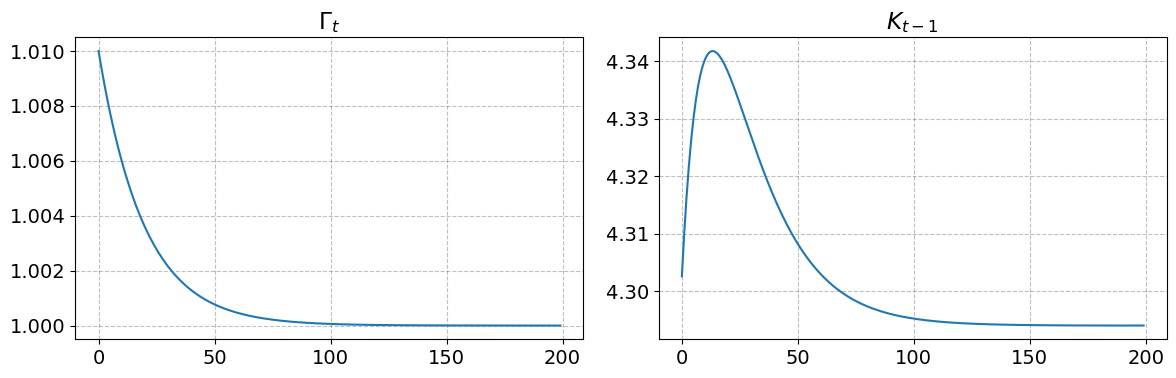

In [15]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
ax.plot(np.arange(T),Gamma_path)
ax.set_title('$\Gamma_{t}$')

ax = fig.add_subplot(1,2,2)
ax.plot(np.arange(T),K_path)
ax.set_title('$K_{t-1}$')

fig.tight_layout()

In [16]:
fig.savefig('figs/Gamma_shock.pdf')